<a href="https://colab.research.google.com/github/GaoangLiu/ipynb/blob/master/NLP_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP with Disaster Tweets

Kaggle contest page: https://www.kaggle.com/c/nlp-getting-started/overview

Task: predicts which Tweets are about real disasters and which one’s aren’t. Return value is either 1 (real) or 0 (unreal) .


In [1]:
# Load packages 
import math
import re
import os
import timeit
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import logging
import time

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
logging.basicConfig(format='[%(asctime)s %(levelname)8s] %(message)s', level=logging.INFO, datefmt='%m-%d %H:%M:%S')

from keras import layers, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
[05-14 06:49:30     INFO] 'pattern' package not found; tag filters are not available for English


## Explore data


In [0]:
! rm tweets.zip labels.csv 
! wget -O tweets.zip ali.140714.xyz:8000/nlp-getting-started.zip 
! unzip tweets.zip 
! ls
! wget -O labels.csv ali.140714.xyz:8000/leaked_tweet_labels.csv


rm: cannot remove 'tweets.zip': No such file or directory
rm: cannot remove 'labels.csv': No such file or directory
--2020-05-14 06:49:42--  http://ali.140714.xyz:8000/nlp-getting-started.zip
Resolving ali.140714.xyz (ali.140714.xyz)... 47.240.16.188
Connecting to ali.140714.xyz (ali.140714.xyz)|47.240.16.188|:8000... failed: Connection timed out.
Retrying.



In [0]:
train = pd.read_csv('train.csv')
train.target.value_counts() 
""" 
0    4342
1    3271
Name: target, dtype: int64
Good, so the data is WELL balanced
"""
train.keyword.value_counts()
train.text.str.len().nsmallest(30)

1882     7
4890     7
5115     7
24       8
30       8
3670     8
4971     8
28       9
3667     9
3749    10
6705    10
22      11
4735    11
5184    11
6015    11
784     12
6522    12
6917    12
7470    12
16      13
2496    13
3696    13
15      14
849     14
6174    14
6277    14
7589    14
900     15
6224    15
6258    15
Name: text, dtype: int64

# CNN
Dive into the data, build a baseline model with CNN

In [0]:
# Base class for classifier
class Classifier():
  def __init__(self):
    self.train = None
    self.test = None 
    self.model = None

  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ Load train, test csv files and return pandas.DataFrame
      """
      self.train = pd.read_csv(train_file, engine='python', encoding='utf-8', error_bad_lines=False)
      self.test = pd.read_csv(test_file, engine='python', encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')
  
  def countvectorize(self):
      tv = TfidfVectorizer(ngram_range=(1,3), token_pattern=r'\w{1,}',
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features=5000)
      tv = CountVectorizer()
      tv.fit(self.train.text)
      self.vector_train = tv.transform(self.train.text)
      self.vector_test  = tv.transform(self.test.text)
      logging.info("Train & test text tokenized")

  def build_model(self):
      pass

  def run_model(self):
      # Choose your own classifier: self.model and run it
      logging.info(f"{self.__class__.__name__} starts running.")
      labels = self.train.target
      x_train, x_val, y_train, y_val = train_test_split(self.vector_train, labels, test_size=0.2, random_state=20)
      self.model.fit(x_train, y_train)
      y_preds = self.model.predict(x_val)

      logging.info(f"Accuracy score: {accuracy_score(y_val, y_preds)}")
      logging.info(f"Confusion matrix: ") 
      print(confusion_matrix(y_val, y_preds))
      print("Classificaiton report:\n", classification_report(y_val, y_preds, target_names=["real", "unreal"]))
      y_preds = self.model.predict(self.vector_test)
      return y_preds

  def save_predictions(self, y_preds):
      sub = pd.read_csv(f"sample_submission.csv")
      sub['target'] = y_preds 
      sub.to_csv(f"submission_{self.__class__.__name__}.csv", index=False)
      logging.info('Prediction exported to submisison.csv')
  
  def pipeline(self):
      s_time = time.clock()
      self.load_data()
      self.countvectorize()
      self.build_model()
      self.save_predictions(self.run_model())
      logging.info(f"Program running for {time.clock() - s_time} seconds")

class C_Bayes(Classifier):
  def build_model(self):
      self.model = MultinomialNB()
      return self.model

# Logistic Regression 
class C_LR(Classifier):
  def build_model(self):
      self.model = LogisticRegression(n_jobs=10, solver='lbfgs', C=0.1, verbose=1)
      return self.model

class C_SVM(Classifier):
  def load_data(self, train_file='train.csv', test_file='test.csv'):
      """ Load train, test csv files and return pandas.DataFrame
      """
      self.train = pd.read_csv(train_file, engine='python', encoding='utf-8', error_bad_lines=False)
      self.test = pd.read_csv(test_file, engine='python', encoding='utf-8', error_bad_lines=False)
      logging.info('CSV data loaded')

  def build_model(self):
      self.model = svm.SVC()
      return self.model

class C_Ensemble(Classifier):
  def ensemble(self):
      s_time = time.perf_counter()
      self.load_data()
      self.countvectorize()

      nb = MultinomialNB()
      lr = LogisticRegression(n_jobs=10, solver='saga', C=0.1, verbose=1)
      svc = svm.SVC()

      all_preds = [0] * self.test.shape[0]
      for m in (nb, lr, svc):
          self.model = m
          if m == svc: 
              self.load_data()
              self.train = self.train.sample(10000)
              self.countvectorize()
          all_preds += self.run_model()

      all_preds = [1 if p > 0 else 0 for p in all_preds]
      self.save_predictions(all_preds)
      logging.info(f"Program running for {time.perf_counter() - s_time} seconds")


class Helper():
    def locate_threshold(self, model, x_val, y_val):
        y_probs = model.predict(x_val, batch_size=1024, verbose=1)
        best_threshold = best_f1 = pre_f1 = 0
        history = []

        for i in np.arange(0.01, 1, 0.01):
          if len(y_probs[0]) >= 2:
              y2_preds = [1 if e[1] >= i else 0 for e in y_probs]
          else:
              y2_preds = (y_probs > i).astype(int)

          cur_f1 = f1_score(y_val, y2_preds, average='weighted')
          history.append((i, cur_f1))
          symbol = '+' if cur_f1 >= pre_f1 else '-'
          # print("Threshold {:6.4f}, f1_score: {:<0.8f}  {} {:<0.6f} ".format(i, cur_f1, symbol, abs(cur_f1 - pre_f1)))
          pre_f1 = cur_f1

          if cur_f1 >= best_f1:
              best_f1 = cur_f1
              best_threshold = i

        print(f"Best f1 score {best_f1}, best threshold {best_threshold}")
        plt.xlabel('Threshold')
        plt.ylabel('f1_score')
        plt.plot(*zip(*history))

        return best_threshold

class C_NN(Classifier):
    def __init__(self, max_features=100000, embed_size=128, max_len=300):
        self.max_features=max_features
        self.embed_size=embed_size
        self.max_len=max_len
    
    def tokenize_text(self, text_train, text_test):
        '''@para: max_features, the most commenly used words in data set
        @input are vector of text
        '''
        tokenizer = Tokenizer(num_words=self.max_features)
        text = pd.concat([text_train, text_test])
        tokenizer.fit_on_texts(text)

        sequence_train = tokenizer.texts_to_sequences(text_train)
        tokenized_train = pad_sequences(sequence_train, maxlen=self.max_len)
        logging.info('Train text tokeninzed')

        sequence_test = tokenizer.texts_to_sequences(text_test)
        tokenized_test = pad_sequences(sequence_test, maxlen=self.max_len)
        logging.info('Test text tokeninzed')
        return tokenized_train, tokenized_test, tokenizer
      
    def build_model(self, embed_matrix=[]):
        text_input = Input(shape=(self.max_len, ))
        embed_text = layers.Embedding(self.max_features, self.embed_size)(text_input)
        if len(embed_matrix) > 0:
            embed_text = layers.Embedding(self.max_features, self.embed_size, \
                                          weights=[embed_matrix], trainable=False)(text_input)
            
        branch_a = layers.Bidirectional(layers.GRU(32, return_sequences=True))(embed_text)
        branch_b = layers.GlobalMaxPool1D()(branch_a)

        branch_c = layers.Dense(32, activation='relu')(branch_b)
        branch_d = layers.Dropout(0.2)(branch_c)
        branch_z = layers.Dense(1, activation='sigmoid')(branch_d)
        
        model = Model(inputs=text_input, outputs=branch_z)
        self.model = model

        return model
        
    def embed_word_vector(self, word_index, model='glove-wiki-gigaword-100'):
        glove = api.load(model) # default: wikipedia 6B tokens, uncased
        zeros = [0] * self.embed_size
        matrix = np.zeros((self.max_features, self.embed_size))
          
        for word, i in word_index.items(): 
            if i >= self.max_features or word not in glove: continue # matrix[0] is zeros, that's also why >= is here
            matrix[i] = glove[word]

        logging.info('Matrix with embedded word vector created')
        return matrix

    def run(self, x_train, y_train):
        checkpoint = ModelCheckpoint('weights_base_best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        early = EarlyStopping(monitor="val_acc", mode="max", patience=3)

        self.model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
        X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=2020)
        BATCH_SIZE = max(16, 2 ** int(math.log(len(X_tra) / 100, 2)))
        logging.info(f"Batch size is set to {BATCH_SIZE}")
        history = self.model.fit(X_tra, y_tra, epochs=10, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), \
                              callbacks=[checkpoint, early], verbose=1)

        return history


## Now try linear models

In [123]:
# c = C_Bayes()
c = C_SVM()
c.pipeline()
labels = pd.read_csv('labels.csv').target
preds = pd.read_csv('submission_C_SVM.csv').target
print("The submission f1_score is: ", f1_score(labels, preds, average='weighted'))


[05-13 14:48:58     INFO] CSV data loaded
[05-13 14:48:58     INFO] Train & test text tokenized
[05-13 14:48:58     INFO] C_SVM starts running.
[05-13 14:49:05     INFO] Accuracy score: 0.7918581746552856
[05-13 14:49:05     INFO] Confusion matrix: 


[[799  77]
 [240 407]]
Classificaiton report:
               precision    recall  f1-score   support

        real       0.77      0.91      0.83       876
      unreal       0.84      0.63      0.72       647

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523



[05-13 14:49:08     INFO] Prediction exported to submisison.csv
[05-13 14:49:08     INFO] Program running for 10.252798000001349 seconds


The submission f1_score is:  0.7897567267823985


Build a simple model and run

In [0]:
c = C_NN(max_features=10000, embed_size=100, max_len=150)
c.load_data()
vector_train, vector_test, tokenizer = c.tokenize_text(c.train.text, c.test.text)

local_matrix = 'glove_twitter_100_matrix.npy'
if os.path.exists(local_matrix):
    matrix = np.load(local_matrix)
    print("Load matrix from local file")
else:
    matrix = c.embed_word_vector(tokenizer.word_index, 'glove-twitter-100')
    np.save(local_matrix, matrix)
    print("Save matrix to local file")

[05-13 12:11:22     INFO] CSV data loaded
[05-13 12:11:22     INFO] Train text tokeninzed
[05-13 12:11:22     INFO] Test text tokeninzed


Load matrix from local file


In [0]:
model = c.build_model(matrix)
c.run(vector_train, c.train.target)
# X_tra, X_val, y_tra, y_val = train_test_split(vector_train, c.train.target, train_size=0.8, random_state=2020)
# history = model.fit(X_tra, y_tra, epochs=3, batch_size=64, validation_data=(X_val, y_val))

[05-13 12:11:27     INFO] Batch size is set to 32


Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 114s 19ms/step - loss: 0.5384 - acc: 0.7335 - val_loss: 0.4476 - val_acc: 0.8017

Epoch 00001: val_acc improved from -inf to 0.80171, saving model to weights_base_best.hdf5
Epoch 2/10
6090/6090 [==============================] - 112s 18ms/step - loss: 0.4386 - acc: 0.8049 - val_loss: 0.4503 - val_acc: 0.7951

Epoch 00002: val_acc did not improve from 0.80171
Epoch 3/10
6090/6090 [==============================] - 111s 18ms/step - loss: 0.4107 - acc: 0.8223 - val_loss: 0.4512 - val_acc: 0.7971

Epoch 00003: val_acc did not improve from 0.80171
Epoch 4/10
6090/6090 [==============================] - 108s 18ms/step - loss: 0.3897 - acc: 0.8322 - val_loss: 0.4286 - val_acc: 0.8102

Epoch 00004: val_acc improved from 0.80171 to 0.81024, saving model to weights_base_best.hdf5
Epoch 5/10
6090/6090 [==============================] - 109s 18ms/step - loss: 0.3745 - acc: 0.8414 - val_loss: 0.4

1523/1523 [==============================] - 0s 127us/step
Best f1 score 0.8210686511812791, best threshold 0.42000000000000004


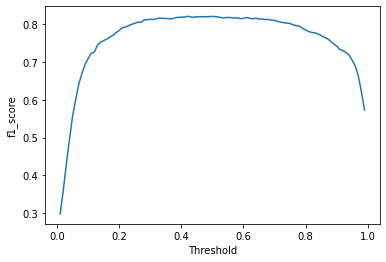

In [0]:
# Find maximum threshold 
model = load_model('weights_base_best.hdf5')
threshold = Helper().locate_threshold(model, X_val, y_val)


In [0]:
# output submission
sub = pd.read_csv('sample_submission.csv')
preds = model.predict(vector_test)

if not threshold:
    threshold = 0.3
preds = (preds >= threshold).astype(int)
sub.target = preds
sub.to_csv('submission.csv', index=False)

labels = pd.read_csv('labels.csv').target
print("The submission f1_score is: ", f1_score(labels, preds, average='weighted'))
# submission result
# GRU 64, max_features = 10000, embed_size=128, max_len=150, no embed, f1_score 0.75460
# GRU 64, max_features = 10000, embed_size=300, max_len=150, Twitter 300, train_size 0.9 (default 0.8), f1_score 0.81083
# GRU 64, max_features = 10000, embed_size=300, max_len=150, Google news 300, train_size 0.9 (default 0.8), f1_score 0.80195
# GRU 64, max_features = 10000, embed_size=300, max_len=150, Google news 300, train_size 0.8 , f1_score 0.80826
# GRU 64, max_features = 10000, embed_size=300, max_len=150, Glove wiki 300, train_size 0.8 , f1_score 0.81352
# GRU 64, max_features = 10000, embed_size=100, max_len=150, Glove wiki 100, train_size 0.8 , f1_score 0.82004
# Double GRU 64, max_features = 10000, embed_size=100, max_len=150, Glove wiki 100, train_size 0.8 , f1_score 0.81252

# LSTM 64, max_features = 10000, embed_size=100, max_len=150, Glove wiki 100, train_size 0.8 , f1_score 0.81177
# Double LSTM 64, max_features = 10000, embed_size=100, max_len=150, Glove wiki 100, train_size 0.8 , f1_score 0.80853


The submission f1_score is:  0.8100469283697781


In [125]:
# upload to vps server
!curl -X PUT --upload-file submission_C_SVM.csv ali.140714.xyz:8000/tweets.csv 


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22746    0     0  100 22746      0  15184  0:00:01  0:00:01 --:--:-- 15174

## Received: "tweets.csv"

100 22775    0    29  100 22746     19  15184  0:00:01  0:00:01 --:--:-- 15193


In [105]:
# Finally, wrap it up and upload zip file to vps server
! rm nlp_disaster_tweets.zip 
! zip -r9 --exclude=sample_data/* nlp_disaster_tweets.zip *
! curl -X PUT --upload-file nlp_disaster_tweets.zip ali.140714.xyz:8000


  adding: glove_twitter_100_matrix.csv (deflated 69%)
  adding: glove_twitter_100_matrix.npy (deflated 59%)
  adding: labels.csv (deflated 64%)
  adding: sample_submission.csv (deflated 66%)
  adding: submission.csv (deflated 65%)
  adding: test.csv (deflated 56%)
  adding: train.csv (deflated 59%)
  adding: tweets.zip (deflated 0%)
  adding: weights_base_best.hdf5 (deflated 26%)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 77 14.7M    0     0   77 11.5M      0  3198k  0:00:04  0:00:03  0:00:01 3198k

## Received: "nlp_disaster_tweets.zip"

100 14.7M    0    42  100 14.7M     10  3750k  0:00:04  0:00:04 --:--:-- 3750k
